Model Phase      MAPE     RMSE      MAE
ARIMA Train       inf 0.106423 0.089811
ARIMA  Test 43.347147 0.418932 0.363118
  SVM Train       inf 0.121284 0.097964
  SVM  Test 28.295526 0.274627 0.235937
 LSTM Train       inf 0.112483 0.092532
 LSTM  Test 23.132250 0.243976 0.197796


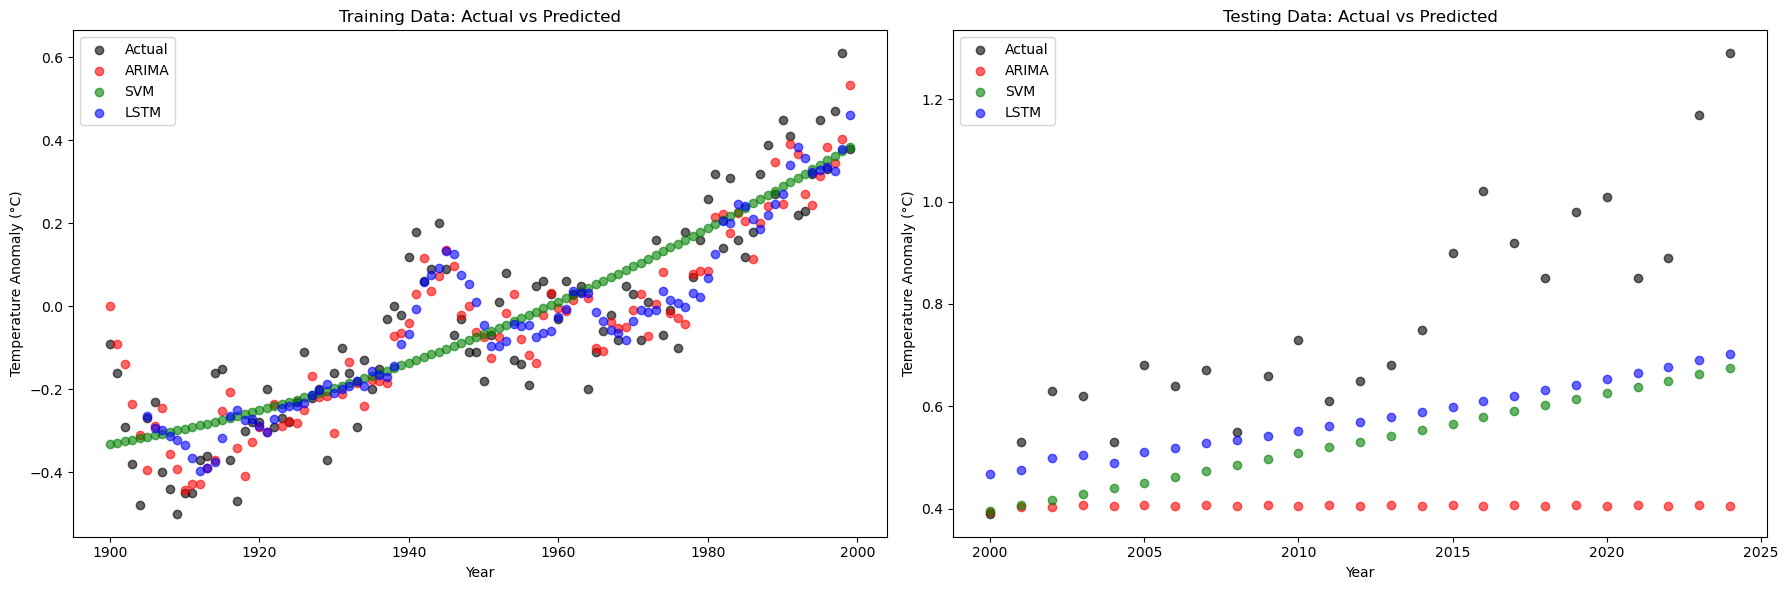

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from statsmodels.tsa.arima.model import ARIMA
import urllib.request

# Download NASA GISTEMP v4 data
url = 'https://data.giss.nasa.gov/gistemp/tabledata_v4/GLB.Ts+dSST.csv'
urllib.request.urlretrieve(url, 'GLB.Ts+dSST.csv')

# Load and clean data
df = pd.read_csv('GLB.Ts+dSST.csv', skiprows=1)
df = df[['Year', 'J-D']].replace('***', np.nan).dropna()
df['Year'] = df['Year'].astype(int)
df['J-D'] = df['J-D'].astype(float)
df = df[df['Year'] >= 1900]

# Train-test split
split_idx = int(0.8 * len(df))
train = df.iloc[:split_idx]
test = df.iloc[split_idx:]

# ARIMA Model
arima_model = ARIMA(train['J-D'], order=(2,1,2))
arima_fit = arima_model.fit()
arima_train_pred = arima_fit.predict(start=0, end=len(train)-1)
arima_test_pred = arima_fit.forecast(steps=len(test))

# SVM Model - Fixed Array Shapes
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
X_train_scaled = scaler_x.fit_transform(train[['Year']])
X_test_scaled = scaler_x.transform(test[['Year']])
y_train_scaled = scaler_y.fit_transform(train[['J-D']])

svm_model = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1)
svm_model.fit(X_train_scaled, y_train_scaled.ravel())

# Fix shape handling for SVM predictions
svm_train_pred = scaler_y.inverse_transform(
    svm_model.predict(X_train_scaled).reshape(-1,1)
).flatten()  # Convert to 1D array

svm_test_pred = scaler_y.inverse_transform(
    svm_model.predict(X_test_scaled).reshape(-1,1)
).flatten()  # Convert to 1D array

# LSTM Model - Final Fixes
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data)-seq_length):
        xs.append(data[i:i+seq_length])
        ys.append(data[i+seq_length])
    return np.array(xs), np.array(ys)

seq_length = 5
scaler_nn = MinMaxScaler()
train_scaled = scaler_nn.fit_transform(train[['J-D']])
X_train_nn, y_train_nn = create_sequences(train_scaled, seq_length)
X_train_nn = X_train_nn.reshape(X_train_nn.shape[0], X_train_nn.shape[1], 1)

model = Sequential([
    LSTM(32, input_shape=(seq_length, 1)),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X_train_nn, y_train_nn, epochs=50, batch_size=8, verbose=0)

# Corrected LSTM prediction function
def lstm_predict(model, train_data, test_length, seq_length):
    inputs = train_data[-seq_length:].flatten().tolist()
    predictions = []
    for _ in range(test_length):
        x = np.array(inputs[-seq_length:]).reshape(1, seq_length, 1)
        pred = model.predict(x, verbose=0)
        predictions.append(pred[0][0])
        inputs.append(pred[0][0])
    return scaler_nn.inverse_transform(np.array(predictions).reshape(-1,1)).flatten()

lstm_test_pred = lstm_predict(model, train_scaled, len(test), seq_length)
lstm_train_pred = scaler_nn.inverse_transform(
    model.predict(X_train_nn, verbose=0)
).flatten()

# Evaluation Metrics with Shape Fixes
def calculate_metrics(actual, predicted, name, phase):
    actual = actual.values if isinstance(actual, pd.Series) else actual
    predicted = predicted.flatten() if predicted.ndim > 1 else predicted
    
    # Handle different lengths for LSTM training data
    min_length = min(len(actual), len(predicted))
    actual = actual[-min_length:]
    predicted = predicted[-min_length:]
    
    return {
        'Model': name,
        'Phase': phase,
        'MAPE': np.mean(np.abs((actual - predicted) / actual)) * 100,
        'RMSE': np.sqrt(mean_squared_error(actual, predicted)),
        'MAE': mean_absolute_error(actual, predicted)
    }

metrics = [
    calculate_metrics(train['J-D'], arima_train_pred, 'ARIMA', 'Train'),
    calculate_metrics(test['J-D'], arima_test_pred, 'ARIMA', 'Test'),
    calculate_metrics(train['J-D'], svm_train_pred, 'SVM', 'Train'),
    calculate_metrics(test['J-D'], svm_test_pred, 'SVM', 'Test'),
    calculate_metrics(train['J-D'][seq_length:], lstm_train_pred, 'LSTM', 'Train'),
    calculate_metrics(test['J-D'], lstm_test_pred, 'LSTM', 'Test')
]

metrics_df = pd.DataFrame(metrics)
print(metrics_df.to_string(index=False))

# Plotting
plt.figure(figsize=(18, 6))

# Training Data Plot
plt.subplot(1, 2, 1)
plt.scatter(train['Year'], train['J-D'], color='black', label='Actual', alpha=0.6)
plt.scatter(train['Year'], arima_train_pred, color='red', label='ARIMA', alpha=0.6)
plt.scatter(train['Year'], svm_train_pred, color='green', label='SVM', alpha=0.6)
plt.scatter(train['Year'][seq_length:], lstm_train_pred, color='blue', label='LSTM', alpha=0.6)
plt.title('Training Data: Actual vs Predicted')
plt.xlabel('Year')
plt.ylabel('Temperature Anomaly (°C)')
plt.legend()

# Testing Data Plot
plt.subplot(1, 2, 2)
plt.scatter(test['Year'], test['J-D'], color='black', label='Actual', alpha=0.6)
plt.scatter(test['Year'], arima_test_pred, color='red', label='ARIMA', alpha=0.6)
plt.scatter(test['Year'], svm_test_pred, color='green', label='SVM', alpha=0.6)
plt.scatter(test['Year'], lstm_test_pred, color='blue', label='LSTM', alpha=0.6)
plt.title('Testing Data: Actual vs Predicted')
plt.xlabel('Year')
plt.ylabel('Temperature Anomaly (°C)')
plt.legend()

plt.tight_layout()
plt.show()
